# 1 Imports

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import duckdb
import seaborn as sns

from ev_load_fc.data.loading import col_standardisation, filtered_chunking
from ev_load_fc.data.analysis import ts_completeness, plot_time_series
from ev_load_fc.data.preprocessing import mad_outlier_bounds, cap_outliers_mad
from ev_load_fc.config import CFG, resolve_path
raw_data_path = resolve_path(CFG["paths"]["raw_data"])
interim_data_path = resolve_path(CFG["paths"]["interim_data"])
images_path = resolve_path(CFG["paths"]["images"])

min_timestamp = datetime(2017,8,1,0,0,0) 
max_timestamp = datetime(2020,3,1,0,0,0)
traffic_data_path = raw_data_path / 'TrafficEvents_Aug16_Dec20_Publish.csv'

## Extract small sample of traffic data to assess structure

In [ ]:
query =  f"""
SELECT * 
FROM '{traffic_data_path}'
LIMIT 100;
"""

traffic_data_sample = duckdb.query(query).to_df()
traffic_data_sample.head()

,EventId,Type,Severity,TMC,Description,StartTime(UTC),EndTime(UTC),TimeZone,LocationLat,LocationLng,Distance(mi),AirportCode,Number,Street,Side,City,County,State,ZipCode
0,T-38768,Congestion,2,73,Severe delays of 18 minutes on US-101 Redwood ...,2016-08-01 00:03:00,2016-08-01 00:14:28,US/Pacific,38.214657,-122.602669,0.0,KO69,<NA>,Redwood Hwy S,R,Petaluma,Sonoma,CA,94952
1,T-38772,Congestion,2,72,Delays of eight minutes on CA-92 San Mateo Rd ...,2016-08-01 00:07:00,2016-08-01 00:18:44,US/Pacific,37.477329,-122.415703,0.0,KHAF,12685,San Mateo Rd,L,Half Moon Bay,San Mateo,CA,94019
2,T-38775,Congestion,2,72,Severe delays of 20 minutes and delays increas...,2016-08-01 00:00:00,2016-08-01 00:18:44,US/Pacific,36.985863,-121.981026,0.0,KWVI,<NA>,State Highway 1,R,Santa Cruz,Santa Cruz,CA,95062
3,T-38777,Congestion,1,75,Delays of two minutes on Valley Fwy Southbound...,2016-08-01 00:08:00,2016-08-01 00:19:44,US/Pacific,37.105865,-121.613411,0.0,KE16,<NA>,S Valley Fwy S,R,San Martin,Santa Clara,CA,95046
4,T-38781,Congestion,2,75,Delays of five minutes on CA-37 Sears Point Rd...,2016-08-01 00:13:00,2016-08-01 00:27:26,US/Pacific,38.150387,-122.450569,0.0,KO69,<NA>,Sears Point Rd,R,Petaluma,Sonoma,CA,94954


In [ ]:
# Use filtered_chunking to load only the relevant date range and counties surrounding Palo Alto
traffic_data = filtered_chunking(traffic_data_path, 
                                 start_date_col='StartTime(UTC)', 
                                 end_date_col='EndTime(UTC)',
                                 date_format='%Y-%m-%d %H:%M:%S',
                                 chunksize=100000, 
                                 min_date=min_timestamp, 
                                 max_date=max_timestamp,
                                 county_list=['San Mateo', 'Santa Clara'])

Chunk: 0
Size of filtered chunk: 0
Chunk: 1
Size of filtered chunk: 0
Chunk: 2
Size of filtered chunk: 0
Chunk: 3
Size of filtered chunk: 0
Chunk: 4
Size of filtered chunk: 0
Chunk: 5
Size of filtered chunk: 0
Chunk: 6
Size of filtered chunk: 0
Chunk: 7
Size of filtered chunk: 0
Chunk: 8
Size of filtered chunk: 0
Chunk: 9
Size of filtered chunk: 0
Chunk: 10
Size of filtered chunk: 0
Chunk: 11
Size of filtered chunk: 0
Chunk: 12
Size of filtered chunk: 0
Chunk: 13
Size of filtered chunk: 0
Chunk: 14
Size of filtered chunk: 0
Chunk: 15
Size of filtered chunk: 0
Chunk: 16
Size of filtered chunk: 0
Chunk: 17
Size of filtered chunk: 0
Chunk: 18
Size of filtered chunk: 0
Chunk: 19
Size of filtered chunk: 0
Chunk: 20
Size of filtered chunk: 0
Chunk: 21
Size of filtered chunk: 0
Chunk: 22
Size of filtered chunk: 0
Chunk: 23
Size of filtered chunk: 0
Chunk: 24
Size of filtered chunk: 0
Chunk: 25
Size of filtered chunk: 0
Chunk: 26
Size of filtered chunk: 0
Chunk: 27
Size of filtered chunk: 0
Ch

In [ ]:
# Save filtered traffic data for ease of access in future
td_filt_path = interim_data_path / 'traffic_data_filt_date_county.csv'
traffic_data.to_csv(td_filt_path, index=False)

# 2 Formatting

In [ ]:
td_filt_path = interim_data_path / 'traffic_data_filt_date_county.csv'
traffic_data = pd.read_csv(td_filt_path)

In [ ]:
traffic_data.head()

,EventId,Type,Severity,TMC,Description,StartTime(UTC),EndTime(UTC),TimeZone,LocationLat,LocationLng,Distance(mi),AirportCode,Number,Street,Side,City,County,State,ZipCode
0,T-10138988,Congestion,0,72,Delays of four minutes and delays increasing o...,2020-02-29 06:16:00,2020-02-29 07:10:46,US/Pacific,37.222050,-121.876541,2.40,KRHV,NaN,Camden Ave,R,San Jose,Santa Clara,CA,95120.0
1,T-10139009,Congestion,0,72,Delays of one minute and delays easing on Winc...,2020-02-29 08:55:00,2020-02-29 09:57:36,US/Pacific,37.291431,-121.949890,0.84,KSJC,1759.0,Winchester Blvd,R,Campbell,Santa Clara,CA,95008.0
2,T-10139010,Congestion,0,72,Delays of one minute on Winchester Blvd Northb...,2020-02-29 09:08:00,2020-02-29 09:50:58,US/Pacific,37.297836,-121.949860,0.57,KSJC,1428.0,S Winchester Blvd,L,San Jose,Santa Clara,CA,95128.0
3,T-10139011,Congestion,0,72,Delays of two minutes on Winchester Blvd North...,2020-02-29 09:10:00,2020-02-29 09:57:36,US/Pacific,37.313347,-121.950012,1.56,KSJC,799.0,S Winchester Blvd,R,San Jose,Santa Clara,CA,95128.0
4,T-10139015,Congestion,1,70,Severe delays of eleven minutes on Junipero Se...,2020-02-29 10:31:00,2020-02-29 11:34:30,US/Pacific,37.640511,-122.441956,0.92,KSFO,344.0,E Junipero Serra Blvd,R,South San Francisco,San Mateo,CA,94080.0


In [ ]:
traffic_data = col_standardisation(traffic_data)

traffic_data.columns

Index(['eventid', 'type', 'severity', 'tmc', 'description', 'starttime',
       'endtime', 'timezone', 'locationlat', 'locationlng', 'distance',
       'airportcode', 'number', 'street', 'side', 'city', 'county', 'state',
       'zipcode'],
      dtype='object')

In [ ]:
# Convert all date columns to pandas datetime
date_cols = ['starttime','endtime']
for col in date_cols:
    traffic_data[col] = pd.to_datetime(traffic_data[col], format="%Y-%m-%d %H:%M:%S")
    
traffic_data.dtypes

eventid                object
type                   object
severity                int64
tmc                     int64
description            object
starttime      datetime64[ns]
endtime        datetime64[ns]
timezone               object
locationlat           float64
locationlng           float64
distance              float64
airportcode            object
number                float64
street                 object
side                   object
city                   object
county                 object
state                  object
zipcode               float64
dtype: object

# 3 Initial Checks

In [ ]:
traffic_data['city'].value_counts()

city
San Jose                    72464
San Mateo                   18099
Mountain View               12039
Palo Alto                   11999
Menlo Park                  11227
Redwood City                11134
Half Moon Bay               10097
Sunnyvale                    9938
Los Gatos                    9362
Morgan Hill                  8059
Milpitas                     7249
Santa Clara                  7044
Gilroy                       6057
Cupertino                    4611
Los Altos                    4513
South San Francisco          4485
Pacifica                     3973
Campbell                     3919
Burlingame                   3455
Brisbane                     2451
Daly City                    2335
Belmont                      2249
San Martin                   2193
Saratoga                     2111
Millbrae                     2108
San Bruno                    2094
Hollister                    1221
San Carlos                   1123
Woodside                     1105
Moss Beac

Using kepler.gl we can clearly see how cities local to Palo Alto contribute to traffic events \
The large white dots signify charging stations 

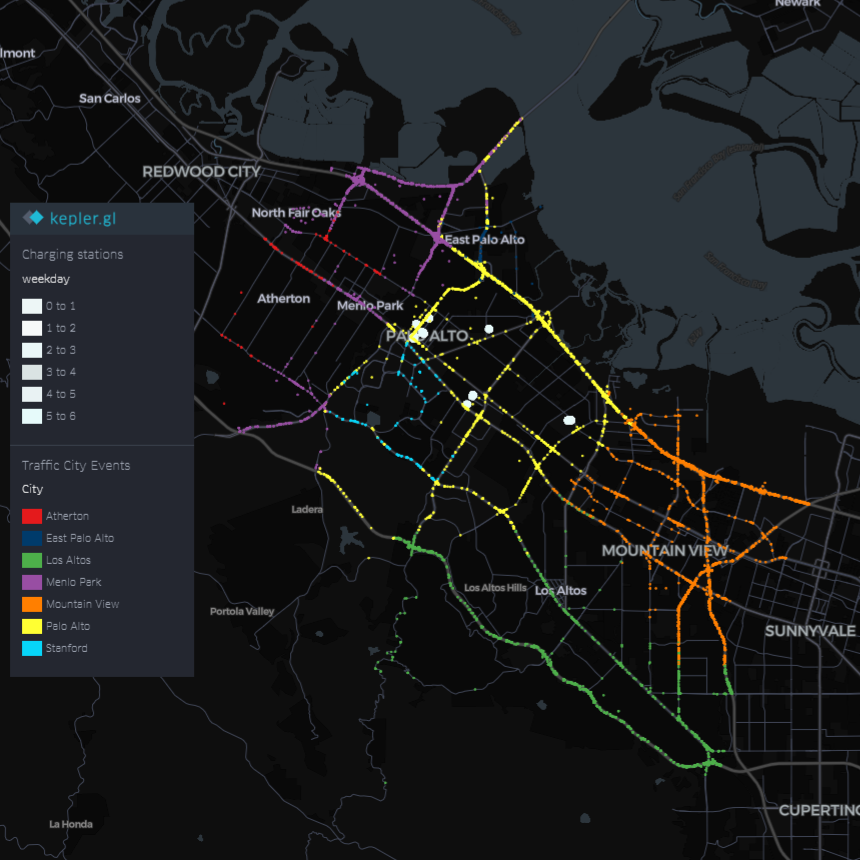

In [2]:
from IPython.display import Image
file_path = images_path / 'kepler_image_traffic_events_by_city.png'
Image(filename=file_path, width=500,height=500) 

In [ ]:
# Filter to cities with traffic events near Palo Alto
traffic_data = traffic_data[traffic_data['city'].isin(['Palo Alto','East Palo Alto','Menlo Park','Stanford','Atherton','Mountain View','Los Altos'])]

In [ ]:
traffic_data.describe()

,severity,tmc,starttime,endtime,locationlat,locationlng,distance,number,zipcode
count,41192.000000,41192.000000,41192,41192,41192.000000,41192.000000,41192.000000,8839.000000,41192.000000
mean,1.013134,110.905880,2018-12-02 17:47:56.982326784,2018-12-02 19:49:01.126626816,37.431993,-122.120466,2.775493,1828.011766,94116.735798
min,0.000000,16.000000,2017-08-01 14:17:00,2017-08-01 15:13:07,37.329350,-122.242332,0.000000,1.000000,94022.000000
25%,0.000000,72.000000,2018-04-16 15:08:45,2018-04-16 16:02:54,37.401299,-122.151482,1.010000,524.000000,94025.000000
50%,1.000000,74.000000,2018-11-30 23:13:02.500000,2018-11-30 23:59:59.500000,37.442612,-122.131836,2.250000,1399.000000,94041.000000
75%,1.000000,76.000000,2019-08-06 00:42:30,2019-08-06 02:10:28,37.471756,-122.079628,3.470000,2554.000000,94303.000000
max,4.000000,1804.000000,2020-02-29 19:55:00,2020-02-29 20:55:38,37.499310,-122.035751,40.290001,31505.000000,94306.000000
std,0.745747,123.028856,NaN,NaN,0.044928,0.041829,3.124788,1893.331312,125.851259


In [ ]:
# Unique values per column
traffic_data.nunique()

eventid        41192
type               7
severity           5
tmc               67
description    17688
starttime      35443
endtime        37676
timezone           1
locationlat     4253
locationlng     3803
distance        1707
airportcode        3
number          1119
street           329
side               2
city               7
county             2
state              1
zipcode           13
dtype: int64

In [ ]:
# Missings breakdown
traffic_data.isnull().sum() 

eventid            0
type               0
severity           0
tmc                0
description        0
starttime          0
endtime            0
timezone           0
locationlat        0
locationlng        0
distance           0
airportcode        0
number         32353
street             0
side               0
city               0
county             0
state              0
zipcode            0
dtype: int64

In [ ]:
# Duplicates
traffic_data[traffic_data.duplicated()]

,eventid,type,severity,tmc,description,starttime,endtime,timezone,locationlat,locationlng,distance,airportcode,number,street,side,city,county,state,zipcode


In [ ]:
traffic_data['type'].value_counts()

type
Congestion        34067
Accident           2570
Flow-Incident      2320
Lane-Blocked        959
Construction        640
Broken-Vehicle      617
Event                19
Name: count, dtype: int64

In [ ]:
traffic_data['severity'].value_counts()

severity
1    20804
0    10344
2     9205
3      837
4        2
Name: count, dtype: int64

In [ ]:
pd.crosstab(traffic_data['type'], traffic_data['severity'])

severity,0,1,2,3,4
type,,,,,
Accident,0,1,2254,315,0
Broken-Vehicle,0,0,484,133,0
Congestion,9513,19953,4601,0,0
Construction,5,2,573,60,0
Event,0,19,0,0,0
Flow-Incident,826,829,613,51,1
Lane-Blocked,0,0,680,278,1


# 4 Time Series Completeness and Visualisation 

In [ ]:
# Create additional time-based columns
traffic_data['month'] = traffic_data['starttime'].dt.to_period('M')
traffic_data['date'] = traffic_data['starttime'].dt.date
traffic_data['hourly_datetime'] = traffic_data['starttime'].dt.round('h')
traffic_data['weekday'] = traffic_data['starttime'].dt.dayofweek

# Duration will be the measureable metric for traffic events as it indicates the impact of the event
traffic_data['duration'] = (traffic_data['endtime'] - traffic_data['starttime']) // pd.Timedelta(minutes=1)

In [ ]:
negative_t_duration = traffic_data[traffic_data['duration']<0]['duration'].count()
print(f"Number of traffic events with negative durations: {negative_t_duration}")

Number of traffic events with negative durations: 0


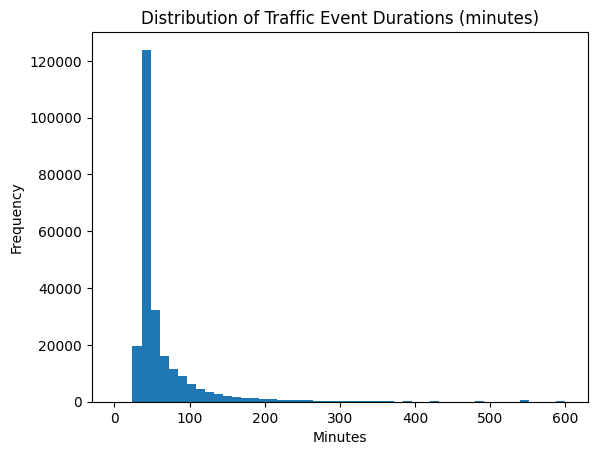

In [ ]:
plt.hist(traffic_data['duration'],bins=50, range=(0,600))
plt.title('Distribution of Traffic Event Durations (minutes)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Outlier detection using MAD
MAD_dict = mad_outlier_bounds(traffic_data, 'duration', threshold=4)
print(MAD_dict)

{'duration': {'median': np.float64(44.0), 'skewed': True, 'max_val': np.float64(104.0), 'min_val': np.float64(32.0)}}


In [ ]:
# Calculate ratio of days with at least one traffic event to total days in dataset
daily_cr = ts_completeness(traffic_data, 'D', 1, 'starttime')
print(f"Daily completeness ratio: {daily_cr:.1%}")

Daily completeness ratio: 98.9%


In [ ]:
# Calculate ratio of hours with at least one traffic event to total hour periods in dataset
hourly_cr = ts_completeness(traffic_data, 'h', 1, 'starttime')
print(f"Hourly completeness ratio: {hourly_cr:.1%}")

Hourly completeness ratio: 84.5%


## Hourly Plots

C:\Users\Cameron\projects\ev_load_fc\src\ev_load_fc\data\loading.py:103: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


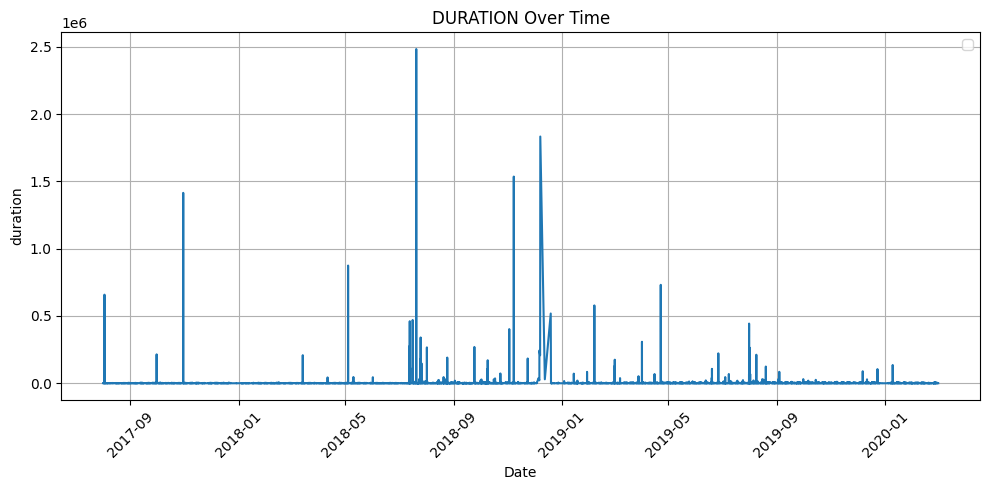

In [ ]:
# Plot time series of traffic event durations per hour
plot_time_series(traffic_data, 'hourly_datetime', 'duration')

In [ ]:
hourly_t_duration = pd.DataFrame(traffic_data.groupby(by=['hourly_datetime'],sort=True)['duration'].sum().reset_index(), columns=['date','duration'])

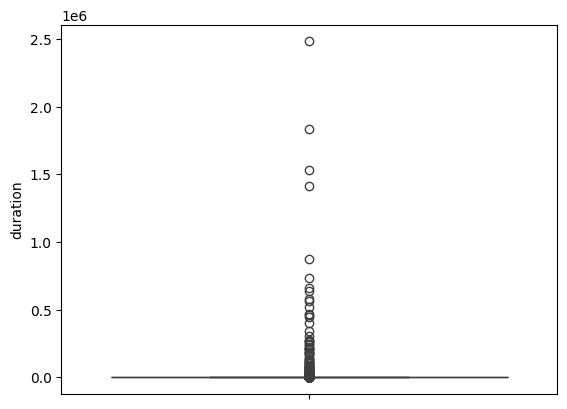

In [ ]:
sns.boxplot(hourly_t_duration['duration'])
plt.show()

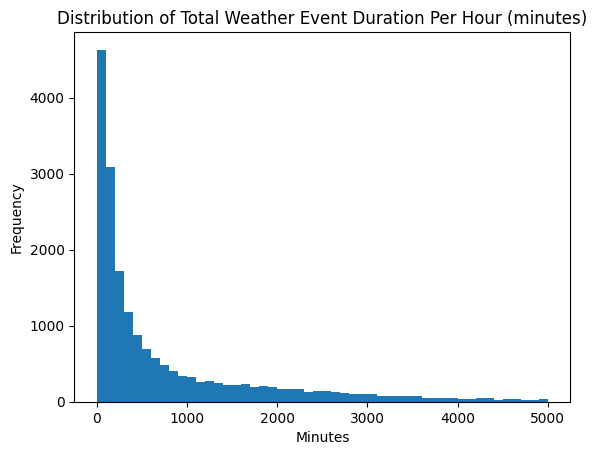

In [ ]:
plt.hist(hourly_t_duration['duration'],bins=50, range=(0,5000))
plt.title('Distribution of Total Weather Event Duration Per Hour (minutes)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Outlier detection using MAD
hourly_mad_dict = mad_outlier_bounds(hourly_t_duration, 'duration', threshold=4)
print(hourly_mad_dict)

{'duration': {'median': np.float64(311.0), 'skewed': True, 'max_val': np.float64(3575.0), 'min_val': np.float64(-517.0)}}


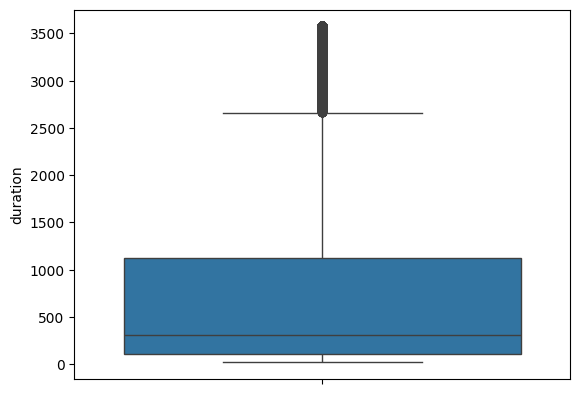

In [ ]:
# Cap outliers based off MAD bounds
capped_hourly_t_dur = cap_outliers_mad(hourly_t_duration, hourly_mad_dict)
# Boxplot of capped durations
sns.boxplot(capped_hourly_t_dur['duration'])
plt.show()

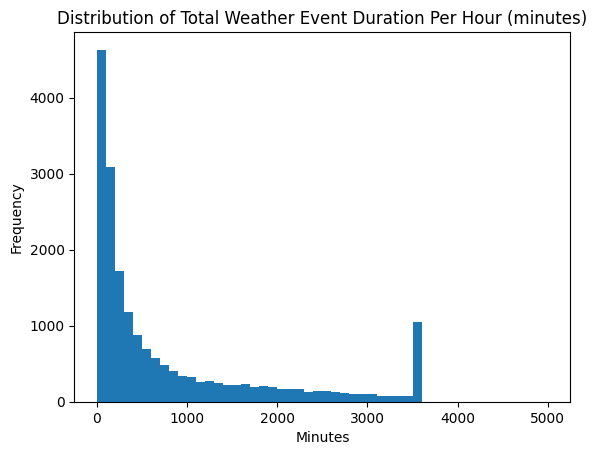

In [ ]:
plt.hist(capped_hourly_t_dur['duration'],bins=50, range=(0,5000))
plt.title('Distribution of Total Weather Event Duration Per Hour (minutes)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

## Daily Plots

C:\Users\Cameron\projects\ev_load_fc\src\ev_load_fc\data\loading.py:103: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


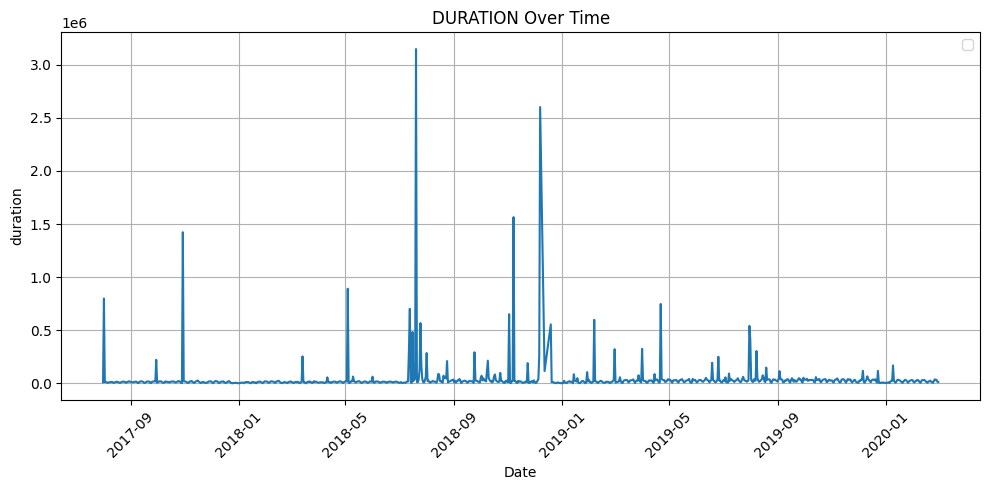

In [ ]:
# Plot time series of traffic event durations per day
plot_time_series(traffic_data, 'date', 'duration')

## Monthly Plots

C:\Users\Cameron\projects\ev_load_fc\src\ev_load_fc\data\loading.py:103: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


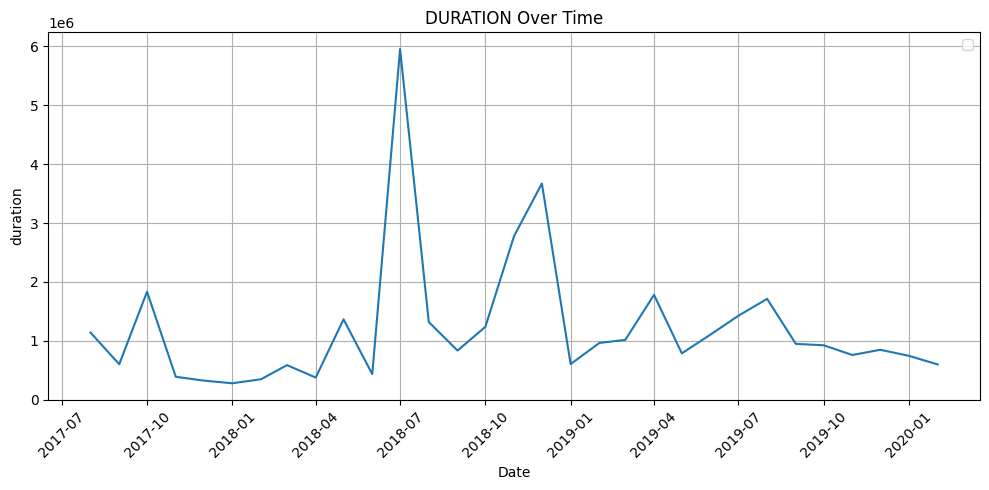

In [ ]:
# Plot time series of traffic event durations per month
plot_time_series(traffic_data, 'month', 'duration')

# 99 Conclusion

Clear right skewed distribution with a heavy tail for traffic event duration.

Very high completeness ratio for both daily and hourly periods traffic data -> Window features on a sub-daily period looking promising.